# Interpolacion con R

In [1]:
getwd()

[1] "C:/Users/GEOMATICA/INIA_Pucallpa/Contrato_3/Investigacion/03_Suelo_Teledeteccion/Script"

In [2]:
setwd(r"(C:\Users\GEOMATICA\INIA_Pucallpa\Contrato_3\Investigacion\03_Suelo_Teledeteccion\Satelite\PUCALLPA)")

In [3]:
# Crear lista del directorio
lista_datos <- list.files(path = getwd(), pattern = '.*xlsx$')
lista_datos

[1] "Extraccion_Bandas_Indices.xlsx"

In [4]:
#install.packages("openxlsx",lib = r"(C:\Program Files\R\R-4.2.2\library)")

In [5]:
library(openxlsx)

In [6]:
dav <- read.xlsx(lista_datos)

In [7]:
head(dav,3)

,ID,ESTE,NORTE,ALTITUD,pH,CE,MO,N,P,K,⋯,SAVI,NDWI,GNDVI,GCI,RVI,CIRE,CVI,MCARI,CCCI,RECI
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,512537.9,9056311,208.22,4.32,1.20,1.48,0.07,27.91,0.21,⋯,1.315546,-0.8122281,0.8122281,8.651220,15.277992,4.701729,6.096746,1914.255,1.103154,14.277992
2,2,512126.2,9057087,201.99,5.00,0.13,2.29,0.11,2.28,0.18,⋯,1.175835,-0.7285068,0.7285068,5.366667,8.259459,2.824781,4.907639,1852.825,1.125182,7.259459
3,3,512766.1,9056489,204.70,4.58,0.16,1.61,0.08,3.68,0.16,⋯,1.190559,-0.7354053,0.7354053,5.558730,8.698947,2.549828,4.945074,2926.009,1.149523,7.698947


In [10]:
library(sp)
library(raster)
library(sf)
library(rgdal)

## Extraer solo Ph

In [13]:
library(tidyverse)
library(dplyr)
library(sf)
library(sp)
library(raster)
library(gstat)
library(fields)
library(interp)
library(mgcv)
library(automap)
library(patchwork)

In [14]:
soil_eea = select(dav, ESTE, NORTE, pH)

In [15]:
sp_suelo = soil_eea

In [16]:
coordinates(sp_suelo) <- ~ESTE + NORTE

In [17]:
st_crs(sp_suelo)

Coordinate Reference System: NA

In [18]:
proj4string(sp_suelo) = CRS("+init=epsg:32718")

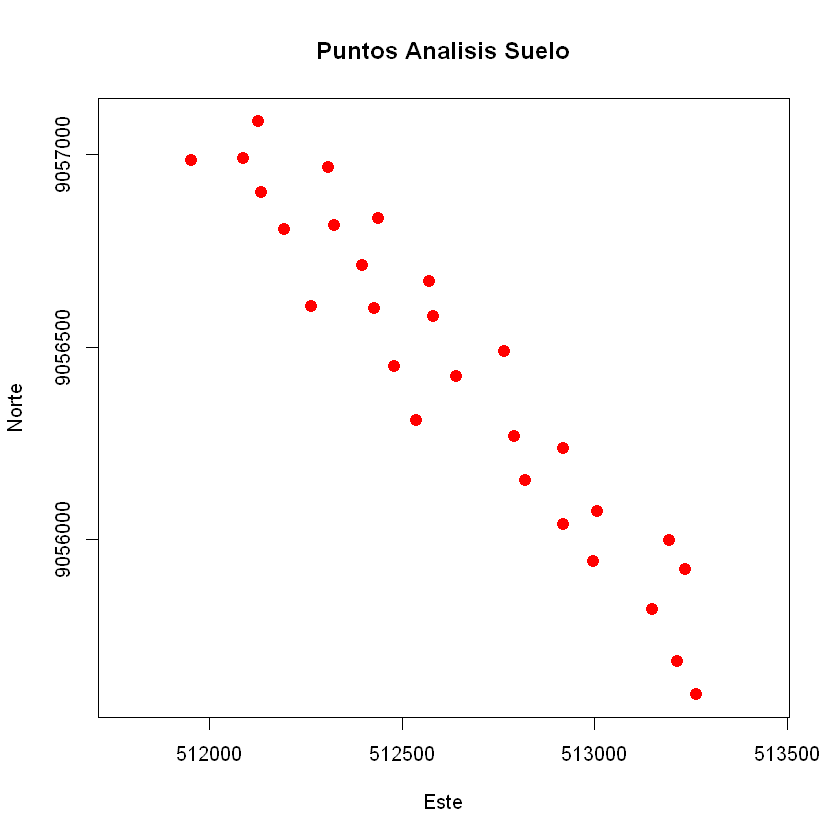

In [19]:
plot(sp_suelo, main = "Puntos Analisis Suelo", xlab = "Este", ylab = "Norte", 
     col= "red", pch = 20, cex = 2, axes = TRUE)

In [20]:
extension_sp = st_bbox(sp_suelo)

In [21]:
extension_sp[4]

ymax 
9057087

In [22]:
# Genera una grilla de 10 m resolution
grd_template <- expand.grid(
  X = seq(from = extension_sp[1], to = extension_sp[3], by = 3),
  Y = seq(from = extension_sp[2], to = extension_sp[4], by = 3) 
)

In [23]:
# Rasterizar nuestro grid
crs_raster_format <- "+proj=utm +zone=18 +south +datum=WGS84 +units=m +no_defs +type=crs"

In [24]:
grd_template_raster <- grd_template %>% 
    dplyr::mutate(Z = 0) %>% 
    raster::rasterFromXYZ( 
    crs = crs_raster_format)

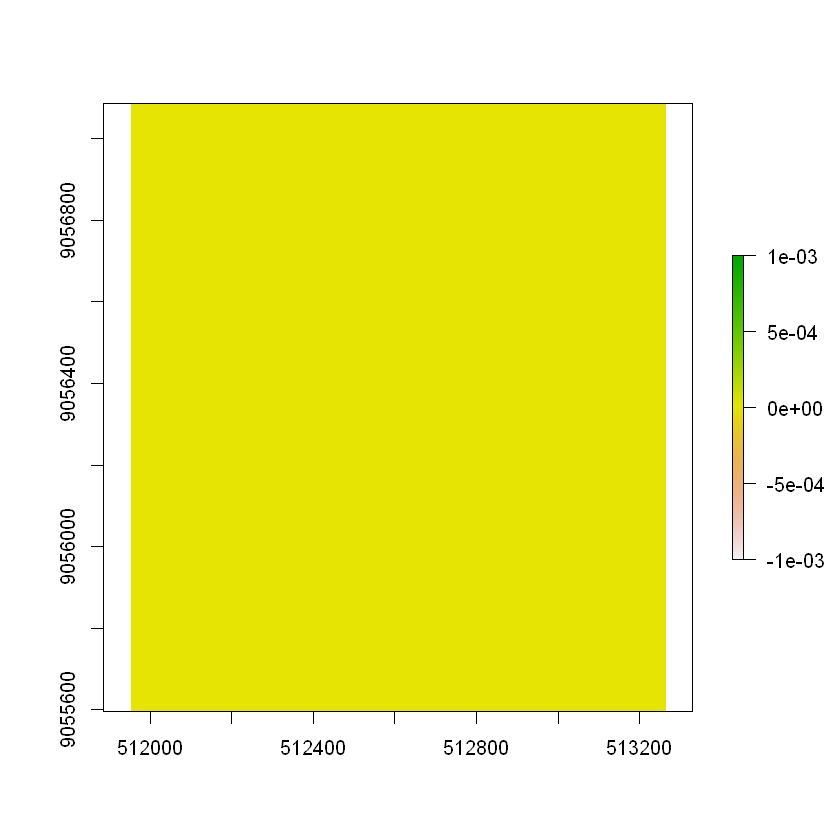

In [25]:
plot(grd_template_raster)

## Vecino Cercano (Nearset Neighbor)

In [43]:
fit_NN <- gstat::gstat( # uso del paquete gstat
    formula = pH ~ 1,    # la columna 'PH' es lo que nos interesa
    data = sp_suelo, # usando {sf} y convirtiendo a {sp}, lo que se espera
    nmax = 10, nmin = 3 # Número de observaciones vecinas utilizadas para el ajuste
    )

## Distancia Inversa Ponderada (IDW)

In [46]:
fit_IDW <- gstat::gstat( 
    formula = pH ~ 1,
    data = sp_suelo,
    nmax = 10, nmin = 3,
    set = list(idp = 0.5) # poder de distancia inversa
    )

In [53]:
#install.packages("fields",lib = r"(C:\Program Files\R\R-4.2.2\library)")

## Regresión spline de placa delgada (TPS)

In [28]:
fit_TPS <- fields::Tps( # usando {fields}
    x = as.matrix(dav[, c("ESTE", "NORTE")]), # acepta puntos pero los espeta como matriz
    Y = sp_suelo$pH,  # la variable dependiente
    miles = FALSE     # EPSG 25833 esta basado en metros
    )

## Modelo aditivo generalizado (GAM)

In [63]:
class(soil_eea)

[1] "data.frame"

In [74]:
soil_eea

,ESTE,NORTE,pH
,<dbl>,<dbl>,<dbl>
1,512537.9,9056311,4.32
2,512126.2,9057087,5.00
3,512766.1,9056489,4.58
4,513263.5,9055598,4.55
5,512480.0,9056451,4.71
6,513006.0,9056074,5.21
7,513216.0,9055683,4.66
8,512792.0,9056269,5.36
9,512919.0,9056237,4.89


In [69]:
set.seed(2) ## simulate some data... 

In [92]:
fit_GAM <- mgcv::gam( # usando {mgcv}
    pH ~ s(ESTE,NORTE),      # aquí vienen nuestros datos X/Y/Z - bastante sencillos
    data = soil_eea   # especificar en qué objeto se almacenan los datos
    )

ERROR: Error in smooth.construct.tp.smooth.spec(object, dk$data, dk$knots): A term has fewer unique covariate combinations than specified maximum degrees of freedom


## Superficie irregular triangular (TIN)

In [82]:
fit_TIN <- interp::interp( # usando {interp}
    x = soil_eea$ESTE,          # la función en realidad acepta vectores de coordenadas
    y = soil_eea$NORTE,
    z = soil_eea$pH,
    xo = grd_template$X,     # aquí definimos la grilla objetivo
    yo = grd_template$Y,
    output = "points"
    ) %>% bind_cols()


## Kriging Automático

In [83]:
fit_KRIG <- automap::autoKrige(      # usando {automap}
    formula = pH ~ 1,                # la interfaz es similar al {gstat} pero
    input_data = sp_suelo # {automap} hace muchas suposiciones por ti
) %>% 
    .$krige_output %>% # la función devuelve un objeto complejo con mucha metainformación
    as.data.frame() %>% # conservamos solo los datos que nos interesa
    dplyr::select(X = x1, Y = x2, Z = var1.pred)

[using ordinary kriging]


# Interpolar

## Triangular Irregular Surface

In [84]:
interp_TIN <- raster::rasterFromXYZ(fit_TIN, crs = crs_raster_format)

In [85]:
interp_KRIG <- raster::rasterFromXYZ(fit_KRIG, crs = crs_raster_format)

In [86]:
# Nearest Neighbor
interp_NN <- interpolate(grd_template_raster, fit_NN)

[inverse distance weighted interpolation]


In [87]:
# Inverse Distance Weighting
interp_IDW <- interpolate(grd_template_raster, fit_IDW)

[inverse distance weighted interpolation]


In [88]:
# Thin Plate Spline Regression
interp_TPS <- interpolate(grd_template_raster, fit_TPS)

In [91]:
# Modelo Aditivo Generalizado
interp_GAM <- grd_template %>% 
  mutate(Z = predict(fit_GAM, .)) %>% 
  rasterFromXYZ(crs = crs_raster_format)

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `Z = predict(fit_GAM, .)`.
[1mCaused by error:[22m
[33m![39m objeto 'ESTE' no encontrado


In [49]:
## Visualización de Resultados de la Interpolación

plot_my_rasters <- function(raster_object, raster_name){
  
  df <- rasterToPoints(raster_object) %>% as_tibble()
  colnames(df) <- c("X", "Y", "Z")
  
  ggplot(df, aes(x = X, y = Y, fill = Z)) +
    geom_raster() +
    ggtitle(label = raster_name) +
    scale_fill_viridis(option = "C") +
    theme_bw() +
    theme(
      axis.text = element_blank(),
      axis.title = element_blank(),
      axis.ticks = element_blank()
    )
}

In [50]:
rasterlist <- list(
    "Nearest Neighbor" = interp_NN, 
    "Inverse Distance Weighted" = interp_IDW, 
    "Kriging" = interp_KRIG, 
    "Thin Plate Spline Regression" = interp_TPS,
    "Triangular Irregular Surface" = interp_TIN, 
    "Generalized Additive Model" = interp_GAM
  )

ERROR: Error in eval(expr, envir, enclos): objeto 'interp_GAM' no encontrado


In [51]:
plotlist <- map2(
  rasterlist,
  names(rasterlist),
  plot_my_rasters
)

ERROR: Error in vctrs_vec_compat(.x, .purrr_user_env): objeto 'rasterlist' no encontrado


In [52]:
(plotlist[[1]] + plotlist[[2]]) /
  (plotlist[[3]] + plotlist[[4]]) /
  (plotlist[[5]] + plotlist[[6]])

ERROR: Error in eval(expr, envir, enclos): objeto 'plotlist' no encontrado
